<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score


In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим на вид данных.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Я решил провести небольшой эксперимент и заполнять не нулями, а предсказывать значения. Спойлер: показатели точности ухудшились, ниже я вернусь к заполнению пропусков нулями. Данный блок эксперимента удалять не стал :)


In [4]:
#Имеем пропуски в Tenure (количество недвижимости у клиента). Пропуски скорее всего означают нулевые значения. #После замены пропусков скорректируем тип данных.

#df['Tenure'] = df['Tenure'].fillna(0).astype(int)



Удалим столбцы не содержащие признаки для обучения модели и округлим значения.

In [5]:
df.columns # для копипаста

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df[['Balance', 'EstimatedSalary']] = df[['Balance', 'EstimatedSalary']].round(0).astype('int')
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0,1,1,1,101349,1
1,608,Spain,Female,41,1.0,83808,1,0,1,112543,0
2,502,France,Female,42,8.0,159661,3,1,0,113932,1
3,699,France,Female,39,1.0,0,2,0,0,93827,0
4,850,Spain,Female,43,2.0,125511,1,1,1,79084,0


In [7]:
df.duplicated().sum() # глянем на явные дубли.

0

## Исследование задачи

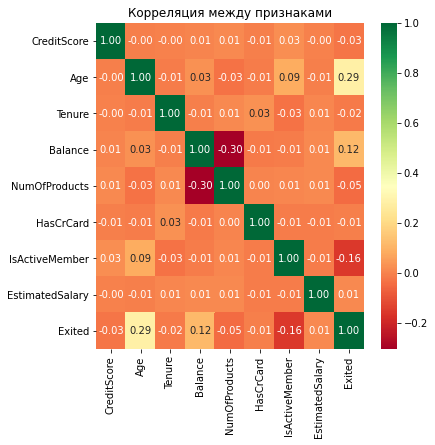

In [8]:
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками')
plt.show()

Видно явное влияние возраста на целевой признак. Также из всех признаков заметно влияние признаков 'IsActiveMember' и  'Balance'. Данный факт не поможет модели обучения, но было интересно это увидеть (я попробовал удалять признаки с 0.01 по модулю значением перед обучением модели, значимого результата не было получено).

In [9]:
#Перекодируем категориальные признаки
df = pd.get_dummies(df, drop_first=True)
df.head(3)
df0 = df.copy()

In [10]:
df.Tenure.describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [11]:
RS = 123

#выделяем часть данных, где имеем пропуски, сохраняем и потом удаляем их из общих данных
df_tenure_pred = df[df['Tenure'].isna()]
df = df.dropna()

#Выделяем фичи и целевой признак для обучения
X = df.drop(['Tenure'], axis=1)
y = df['Tenure']

#берем фичи, где хотим предсказывать целевой признак
X_pred = df_tenure_pred.drop(['Tenure'], axis=1)

#разбиваем выборку на обучающую и тестовую
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=1/4, random_state=RS)

In [12]:
df.shape

(9091, 12)

In [13]:
df_tenure_pred.shape

(909, 12)

In [14]:
# подтягиваем код который уже писали ниже. На этом этапе уже стоило бы написать функцию, 
# но так как все проект правлю на коленке, просто скопипастю

params = {'n_estimators': range(5, 100) , 'max_depth': range(1, 20)} 
rfc = RandomForestClassifier(random_state=RS)
clf = RandomizedSearchCV(rfc, params, n_jobs=-1, cv=2)
clf.fit(X_train, y_train)
clf.best_params_  

{'n_estimators': 69, 'max_depth': 5}

In [15]:
clf.score(X_test, y_test) 

0.10910690717113947

In [16]:
y = clf.predict(X_pred)
y[100:300]

array([1., 2., 2., 1., 3., 8., 2., 2., 1., 1., 2., 7., 8., 1., 2., 7., 7.,
       1., 8., 8., 2., 8., 1., 9., 2., 1., 5., 8., 4., 9., 8., 7., 7., 2.,
       4., 1., 5., 1., 7., 7., 6., 8., 1., 8., 1., 1., 3., 1., 1., 1., 5.,
       1., 5., 1., 7., 7., 1., 5., 9., 1., 2., 5., 5., 2., 8., 2., 5., 7.,
       5., 1., 8., 7., 9., 1., 1., 2., 4., 1., 2., 6., 8., 8., 2., 8., 5.,
       1., 2., 2., 8., 5., 5., 4., 2., 7., 8., 8., 5., 2., 7., 1., 2., 1.,
       1., 1., 1., 7., 2., 7., 5., 1., 2., 2., 1., 5., 1., 1., 3., 5., 1.,
       1., 1., 1., 9., 1., 2., 8., 1., 5., 1., 1., 5., 1., 1., 7., 2., 1.,
       4., 9., 1., 1., 1., 8., 6., 5., 2., 1., 2., 1., 5., 7., 5., 1., 2.,
       1., 8., 2., 2., 1., 2., 2., 4., 7., 2., 2., 8., 1., 5., 1., 2., 1.,
       9., 6., 7., 7., 2., 8., 3., 5., 7., 8., 7., 1., 7., 3., 7., 1., 2.,
       5., 1., 5., 1., 8., 5., 5., 2., 7., 7., 1., 2., 1.])

Похоже, что модель предсказывает адекватные данные.

In [17]:
df_tenure = pd.concat([X_pred, pd.Series(y, index=X_pred.index)], axis=1)
df_tenure.head(2)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,0
30,591,39,0,3,1,0,140469,1,0,1,0,5.0
48,550,38,103391,1,0,1,90878,0,1,0,1,1.0


In [18]:
df_tenure.rename(columns = {0:'Tenure'}, inplace = True)
df_tenure.head(2)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Tenure
30,591,39,0,3,1,0,140469,1,0,1,0,5.0
48,550,38,103391,1,0,1,90878,0,1,0,1,1.0


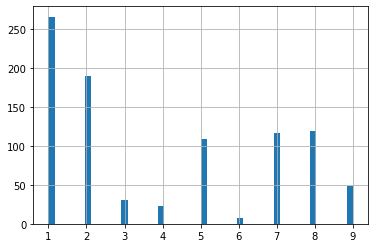

In [22]:
df_tenure['Tenure'].hist(bins=50);

In [19]:
df = pd.concat([df, df_tenure], axis=0)
df.shape

(10000, 12)

In [20]:
df.Tenure.describe()

count    10000.000000
mean         4.826100
std          2.915529
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

Показатель точности модели оставляет желать лучшего. Но улучшить показатели мне не удалось. Возможно тут стоило использовать другой подход к классификации или возможно, использовать регрессию. Но в любом случае характер распределения почти не изменился, данный подход, полагаю, будет лучше, тем заполнение значений случайными значениями.

In [21]:
df.info() # глянем, все ли в норме после преобразований датафрейма

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  int64  
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  int64  
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(1), int64(8), uint8(3)
memory usage: 810.5 KB


Как я и говорил, возвращаем все на место. Эксперимент провалился)


In [22]:
df = df0.copy()
df['Tenure'] = df['Tenure'].fillna(0).astype(int)
df.shape

(10000, 12)

## Борьба с дисбалансом

In [23]:
df.Exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Виден дисбаланс классов 0/1 : 4/1 соотвественно. Для борьбы с дисбалансом будем использовать методы upsamling и downsampling, а также воспользуемся встроенным параметров модели.


In [24]:
X = df.drop(['Exited'], axis=1)
y= df['Exited']

In [25]:
RS = 12345
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=1/4, random_state=RS)

In [26]:
train = pd.concat([X_train, y_train], axis=1)

df_exited_yes = train[train.Exited==0]
df_exited_no = train[train.Exited==1]
print(df_exited_yes.shape)
print(df_exited_no.shape)


(5998, 12)
(1502, 12)


In [27]:
RS=123

df_exited_no_up = resample(df_exited_no, replace=True, 
                           n_samples=len(df_exited_yes), random_state=RS)
train_up = pd.concat([df_exited_yes, df_exited_no_up])
X_train_up = train_up.drop(['Exited'], axis=1)
y_train_up = train_up['Exited']


df_exited_yes_down = resample(df_exited_yes, replace=False, 
                              n_samples=len(df_exited_no), random_state=RS)
train_down = pd.concat([df_exited_no, df_exited_yes_down])
X_train_down = train_down.drop(['Exited'], axis=1)
y_train_down = train_down['Exited']
X_train_up.shape

(11996, 11)

In [28]:
#код ревьюера
df_exited_yes_down.duplicated().sum()

0

## Тестирование модели

В качестве модели будем использовать Random Forest (RF). Для данной модели условия масштабирования признаков не является обязательным.  
Поэтому этот этап обработки можно пропустить. Будем использовать RandomizedSearchCV, поэтому валидационная выборка не обязательна.

Фукнция, которая выводит результаты обучения и метрики качества обучения:

In [29]:
def get_resume(clf, x, y, scv=True): #scv - SearchCV
    print('Результаты обучения модели:')
    if scv: # если это серч
        print('лучшие параметры:', clf.best_params_)
    vld_pred = clf.predict(x)
    print('f1-мера:', f1_score(y, vld_pred))
    print('roc-auc-мера:', roc_auc_score(y, clf.predict_proba(x)[:, 1]))
    
    cm = confusion_matrix(y_test, vld_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

Результаты обучения модели:
лучшие параметры: {'n_estimators': 169, 'max_depth': 16}
f1-мера: 0.5697399527186761
roc-auc-мера: 0.8508225725904258


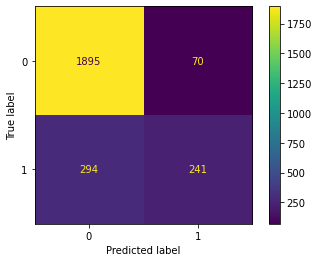

In [30]:
params = {'n_estimators': range(5, 200) , 'max_depth': range(1, 20)} 
rfc = RandomForestClassifier(random_state=RS)
clf = RandomizedSearchCV(rfc, params, n_jobs=-1, random_state=RS)
clf.fit(X_train, y_train)
get_resume(clf, X_test, y_test)

На исходных данных f1-мера ниже требуемой. Попробуем обучить модель на сэмплированных данных:

Результаты обучения модели:
f1-мера: 0.6275720164609054
roc-auc-мера: 0.8549485148985756


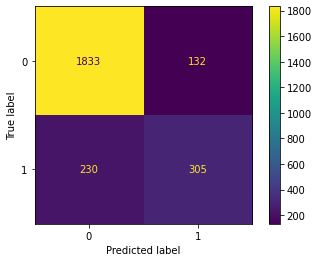

In [31]:
rfc.set_params(**clf.best_params_) # установим оптимальные гиперпараметры RF, чтобы не повторять их поиск.
rfc.fit(X_train_up, y_train_up) # обучим модель на upsample выборке
get_resume(rfc, X_test, y_test, scv=False)

<b>f1 - мера получилась выше требуемой. Требуемый результат получен.  





  
Обучим модель на downsample выборке. Предположительно, результат будет не лучше того, что получился на общей выборке.

Результаты обучения модели:
f1-мера: 0.6115581565471836
roc-auc-мера: 0.8549580271574992


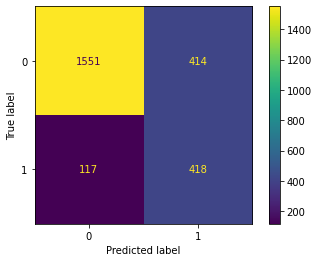

In [32]:
rfc.fit(X_train_down, y_train_down)
get_resume(rfc, X_test, y_test, scv=False)

Выяснилось, что даже на downsample выборке результат f1-меры оказался лучше, но roc-auc оказался немного меньше, т.к. значительно увеличился показатель FP, что в свою очередь связано с уменьшением выборки класса 0 - поэтому модель стала хуже предсказывать этот класс.

Теперь воспользуемся встроенными в модель методами балансировки классов (https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/#free-courses)

In [33]:
len_ex0 = train[train.Exited==0].shape[0]
len_ex1 = train[train.Exited==1].shape[0]
w0 = len(df)/(2 * len_ex0)
w1 = len(df)/(2 * len_ex1)
print(w0, w1)

0.8336112037345782 3.3288948069241013


Результаты обучения модели:
лучшие параметры: {'n_estimators': 130, 'max_depth': 18}
f1-мера: 0.5666666666666667
roc-auc-мера: 0.8526884021783073


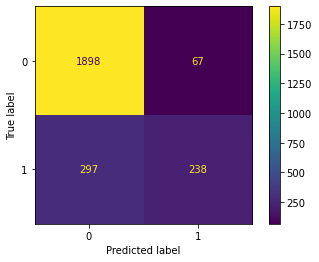

In [34]:
params = {'n_estimators': range(5, 200) , 'max_depth': range(1, 20)} 
rfc = RandomForestClassifier(random_state=RS, class_weight={0: w0, 1: w1})
clf = RandomizedSearchCV(rfc, params, n_jobs=-1)
clf.fit(X_train, y_train)
get_resume(clf, X_test, y_test, scv=True)

Результат чуть лучше обучения на исходных данных, но хуже чем на сэмплированных. 

<b> Вывод:
Проведена предобработка данных, проведен краткий исследовательский анализ данных.  
Категориальные переменные преобразованы методом OneHotEncoding.  
Выявлен дисбаланс классов, для их устранения были применены методы upsampling, downsampling, весовая балансировка классов при обучении модели.  
Изначально была выбрана модель RF, которая наиболее эффективна на задачах такого рода, кроме того не пришлось масштабировать признаки. Подобраны гиперпараметры с помощью класса RandomizedSearchCV, произведено тестирование модели и сравнение результатов f1-меры. После обучения модели выявлено, что наилучшие результаты дает upsampling, downsampling, весовая балансировка классов, исходные признаки -  в порядке убывания.
Лучшие гиперпараметры модели: 'n_estimators': 169, 'max_depth': 16, метрики качества: f1-мера: 0.6275720164609054
roc-auc-мера: 0.8549485148985756.
